In [1]:
import torch
from ANARX import ANARX, LAGNET
from ANARX_SS import ANARX_SS
from utilities import lag_matrix
#%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from tqdm import tqdm
from pathlib import Path
print(Path.cwd())

c:\Users\vh\Documents\Projektmodul\Valentin macht alles neu\unified


In [2]:
model = torch.load("models/sanarx_14_5_3.pt")
data = scipy.io.loadmat("data/1803")
input = data["u2_t"]
out = data["y_t"]

In [3]:
INPUT_LAGS = 5
OUTPUT_LAGS = 14

In [4]:
out = torch.Tensor(out).squeeze()
input = torch.Tensor(input).squeeze()
in_lagged = lag_matrix(input, INPUT_LAGS)
out_lagged = lag_matrix(out, OUTPUT_LAGS)

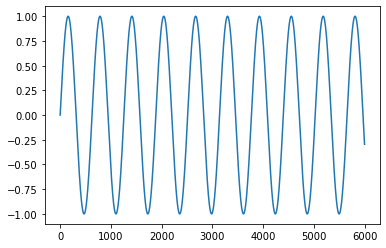

In [5]:
sinewave = np.sin(np.arange(0, 60, 0.01))
step = np.concatenate((np.zeros(2000), .3*np.ones(2000), np.zeros(2000)))
plt.plot(sinewave)
# plt.show()

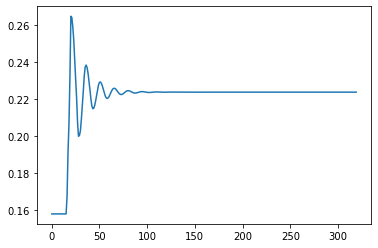

In [6]:
y_hat = model.justpredict([input])
plt.plot(y_hat[2280:2600])
# plt.plot(out)
# plt.plot(step[1980:2200])
plt.show()

In [7]:
x = torch.zeros(model.n_subnets).float()

def nextState(x, u):
    inputs = []
    for i in range(model.n_subnets):
        if model.lag_map[i][0] == 1:
            inputs.append(torch.cat((torch.unsqueeze(u, dim=0), torch.unsqueeze(x[0], dim=0))))
        else:
            inputs.append(torch.unsqueeze(x[0], dim=0))
            
    next = torch.zeros(model.n_subnets)
    for i in range(model.n_subnets-1):
        next[i] = x[i+1] + model.subnets[i](inputs[i])
    next[model.n_subnets-1] =  model.subnets[model.n_subnets - 1](inputs[model.n_subnets-1])
    return next
y = []
for i in tqdm(range(6000)):
    y.append(x[0].detach().numpy())
    x = nextState(x, input[i])

100%|██████████| 6000/6000 [00:16<00:00, 365.92it/s]


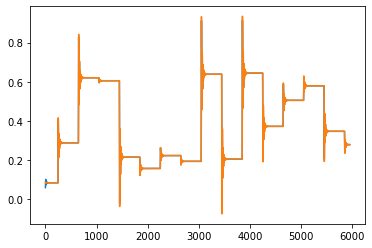

In [8]:
plt.plot(y[50:])
plt.plot(y_hat[50:])

Torch Linear Funktion:

$ \eta_1(t) = \left[u(t), y(t)\right]^T\cdot A^T + b $ bzw.
$ u(t)\cdot a_1 + y(t) \cdot a_2 + b = \eta_1(t)$

dannn lässt sich u(t) invers bestimmen:
$ u(t) = \dfrac{\eta_1(t)-y(t)\cdot a_2 - b}{a_1}$

In [9]:
a1 = model.subnets[0].linear_layers[0].weight[0,0]
a2 = model.subnets[0].linear_layers[0].weight[0,1]
b = model.subnets[0].linear_layers[0].bias
b

In [10]:
x = torch.zeros(model.n_subnets).float()
controlled_input = torch.zeros_like(input)
eta = torch.zeros(model.n_subnets).float()


def nextState(x, u):
    inputs = []
    #print(model.lag_map)
    for i in range(model.n_subnets):
        if model.lag_map[i][0] == 1:
            inputs.append(torch.cat((torch.unsqueeze(u, dim=0), torch.unsqueeze(x[0], dim=0))))
        else:
            inputs.append(torch.unsqueeze(x[0], dim=0))
    # print(inputs)

    next = torch.zeros(model.n_subnets)
    for i in range(model.n_subnets-1):
        next[i] = x[i+1] + model.subnets[i](inputs[i])
    next[model.n_subnets-1] =  model.subnets[model.n_subnets - 1](inputs[model.n_subnets-1])
    return next
y = []
for i in tqdm(range(5999)):
    y.append(x[0].detach().numpy())
    controlled_input[i] = (step[i]-x[1] - torch.Tensor(x[0]) * a2 - b)/a1
    x = nextState(x, controlled_input[i])

100%|██████████| 5999/5999 [00:17<00:00, 335.21it/s]


In [11]:
controlled_input = torch.zeros_like(input)
x = torch.zeros(model.n_subnets).float()


modelss = ANARX_SS(model)
y = []
for i in tqdm(range(5999)):
    y.append(x[0].detach().numpy())
    controlled_input[i] = (sinewave[i]-x[1] - torch.Tensor(x[0]) * a2 - b)/a1
    x = modelss(x, torch.unsqueeze(x[0], dim=0), torch.unsqueeze(controlled_input[i], dim=0))

100%|██████████| 5999/5999 [00:19<00:00, 314.89it/s]


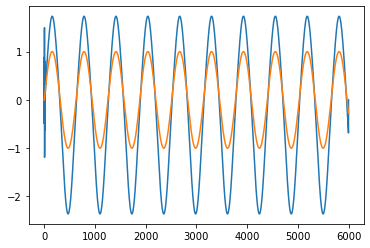

In [12]:
plt.plot(controlled_input.detach().numpy())
# plt.plot(sinewave)
plt.plot(y)


In [13]:
for i in range(model.n_subnets):
    if sum(model.lag_map[i]) == 2:
        torch.onnx.export(model.subnets[i], torch.randn((2)), f"onnx/{i}.onnx")
    else:
        torch.onnx.export(model.subnets[i], torch.randn((1)), f"onnx/{i}.onnx")


In [16]:
torch.onnx.export(modelss, (torch.ones(modelss.n_subnets).float(), torch.ones(1), torch.ones(1)), f"onnx/full.onnx", opset_version=11, input_names=["state", "last_output", "input"], output_names=["next_state"])

In [15]:
print(model.lag_map)
print(model.subnets[1](torch.Tensor([1,0])))

{0: [1, 1], 1: [1, 1], 2: [1, 1], 3: [1, 1], 4: [1, 1], 5: [0, 1], 6: [0, 1], 7: [0, 1], 8: [0, 1], 9: [0, 1], 10: [0, 1], 11: [0, 1], 12: [0, 1], 13: [0, 1]}
tensor([0.4050], grad_fn=<AddBackward0>)
